In [2]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels import PooledOLS
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

import pandas as pd
import pyreadstat as py
import pyreadstat
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Домашнее задание по эконометрике выполняли студенты группы БЭК182 Ильин Андрей и Веденеев Роман

## 1. "Взять языка"

In [3]:
df = pd.read_excel('pogodamosc.xlsx')
df.index = pd.PeriodIndex(df.date_oper, freq='M')

pogoda = df.temperature

osadki = df.precipitation

#### В качестве временного ряда взяты среднемесячные температуры воздуха в Москве  (столбец temperature) с 2016 по май 2021 года (в сумме 65 месяцев). В качестве дополнительного ряда взяты месячные суммы выпавших осадков в Москве (столбец precipitation). Данные взяты с сайта http://www.pogodaiklimat.ru/history/27612.htm

## 2. "Намалевич"

#### График для температуры

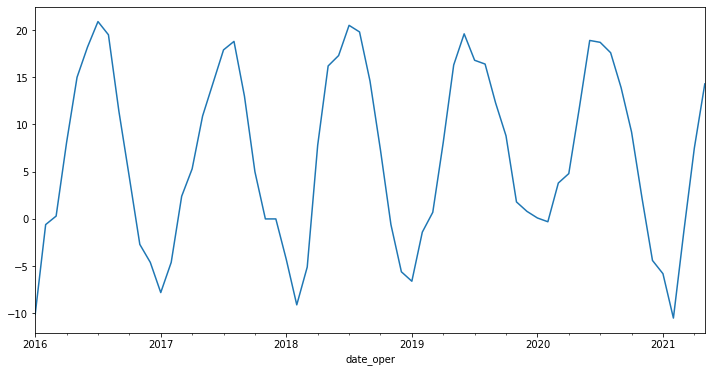

In [4]:
pogoda.plot(figsize=(12,6))

plt.show()

#### График для осадков

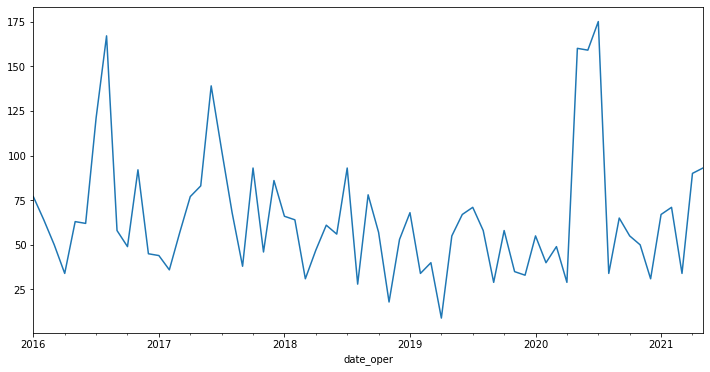

In [5]:
osadki.plot(figsize=(12,6))

plt.show()

### График автокорреляционной функции

#### ACF для температуры

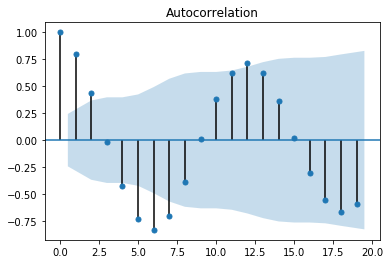

In [6]:
plot_acf(pogoda)

plt.show()

#### ACF для осадков

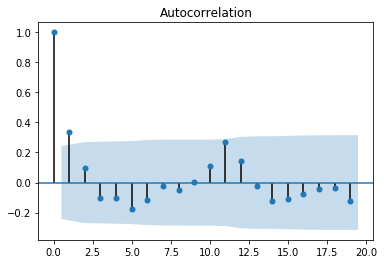

In [7]:
plot_acf(osadki)

plt.show()

#### PACF для температуры

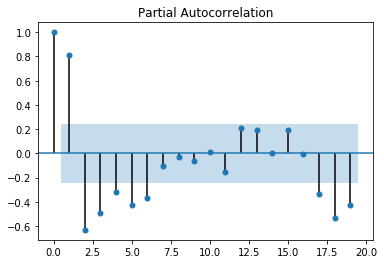

In [8]:
plot_pacf(pogoda)

plt.show()

#### PACF для осадков

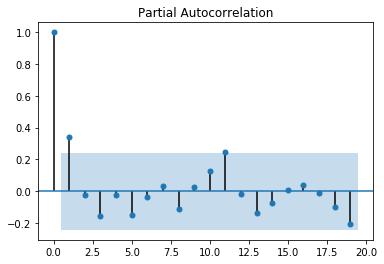

In [9]:
plot_pacf(osadki)

plt.show()

### График с нарезкой ряда на годы

#### График для температуры

C:\Users\andrilin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\andrilin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\andrilin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\andrilin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__i

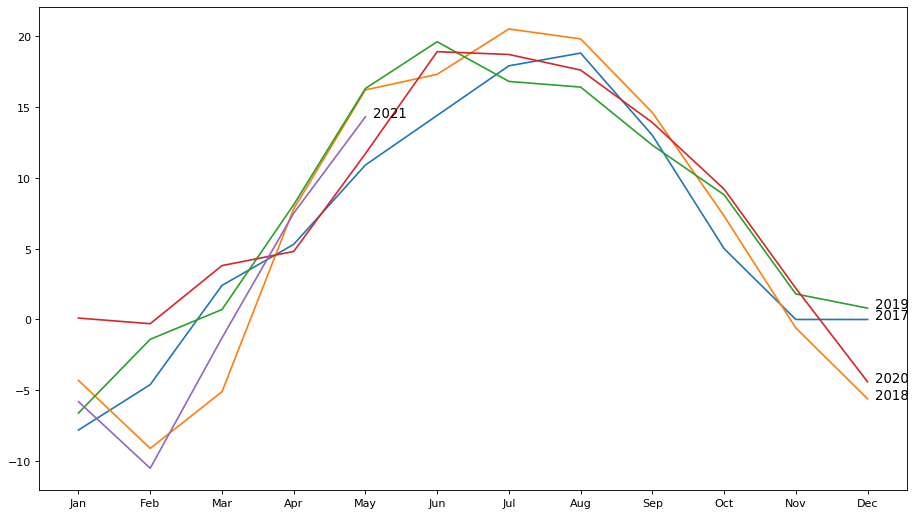

In [10]:
df['year'] = [d.year for d in df.date_oper]
df['month'] = [d.strftime('%b') for d in df.date_oper]
years = df['year'].unique()

plt.figure(figsize=(14,8), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'temperature', data=df.loc[df.year==y, :], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'temperature'][-1:].values[0], y, fontsize=12)

plt.show()

#### График для осадков

C:\Users\andrilin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\andrilin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\andrilin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
C:\Users\andrilin\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\__i

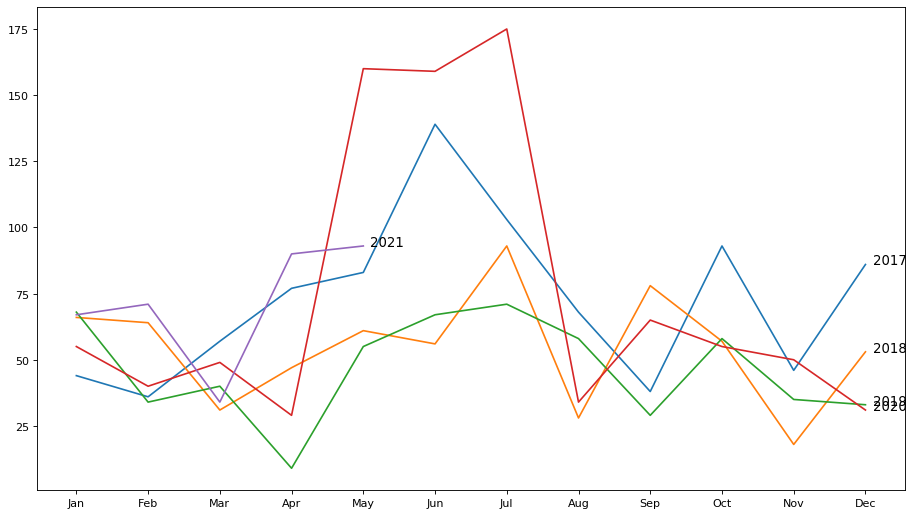

In [11]:
plt.figure(figsize=(14,8), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'precipitation', data=df.loc[df.year==y, :], label=y)
        plt.text(df.loc[df.year==y, :].shape[0]-.9, df.loc[df.year==y, 'precipitation'][-1:].values[0], y, fontsize=12)

plt.show()

## 3. "Твиттер"

#### Температура: без сомнений температура является сезонным рядом, особенно московская погода. Умеренный климат, характерный центральной части нашей Родины, явно виден на полученных графиках, когда есть явное лето и явная зима.

#### Тренд температуры последних четырех лет был умеренно восходящим: при стабильности летних температур столицы, росли зимние температуры от года к году, однако холодная зима 2021 года в щепки разбила тревоги экологов, оказавшись наиболее яркой точкой излома, которые характеры для температуры Москвы два раза в году: зимой и весной

#### Амплитуда ряда является весьма стабильной. Однако она несколько сокращалась с 2016 по 2020 год, вернувшись на исходные позиции в начале 2021.

#### График очевидно является НЕстационарным: особенно это видно на ACF модели - ошибки, в большой степени, объясняются сезонностью

## 4. "Двендацать месяцев"

### Наивная,ˆyt+1=yt

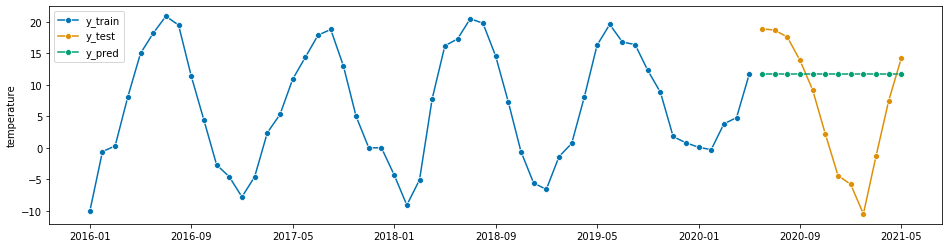

In [12]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    mean_absolute_percentage_error,
)
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import ARIMA, AutoARIMA

y_train, y_test = temporal_train_test_split(df.temperature, test_size=12)
fh = ForecastingHorizon(y_test.index, is_relative=False)



forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()

#### MAE этой модели:

In [13]:
mean_absolute_percentage_error(y_pred, y_test)

0.9791134042575935

### Сезонная наивная,ˆyt+1=yt+1−12

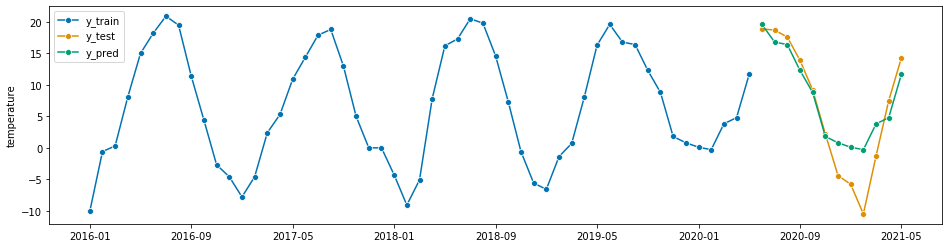

In [14]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()

#### MAE этой модели:

In [15]:
mean_absolute_percentage_error(y_pred, y_test)

0.7590407711113557

### SARIMA(1, 1, 1)(1, 0, 0)[12]

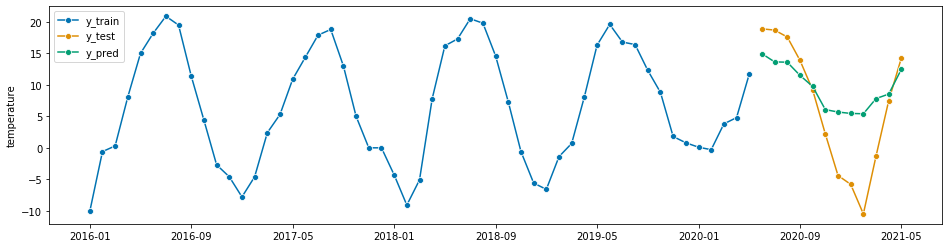

In [16]:
forecaster = ARIMA(
    order=(1, 1, 1), seasonal_order=(1, 0, 0, 12), suppress_warnings=True
)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()

#### MAE этой модели:

In [17]:
mean_absolute_percentage_error(y_pred, y_test)

0.8540582896506201

### Алгоритм Хиндмана-Хандакара автоматического подбора SARIMA

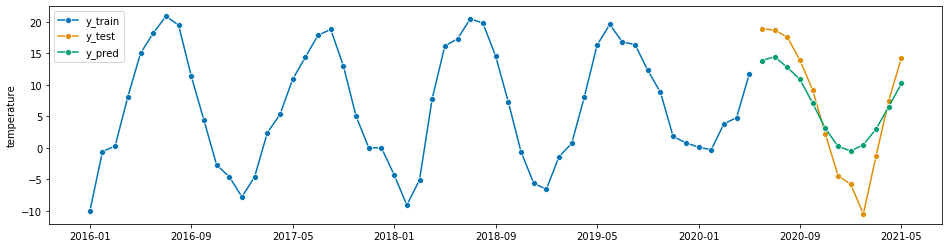

In [18]:
from sktime.forecasting.arima import ARIMA, AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

plt.show()

#### MAE этой модели:

In [24]:
mean_absolute_percentage_error(y_pred, y_test)

0.706452787517304

### ETS(AAA)

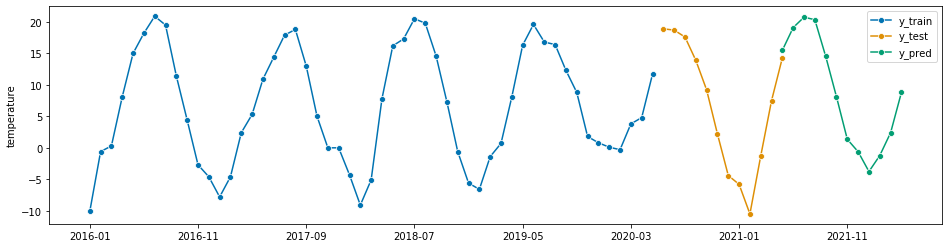

In [25]:
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
plt.show()

#### MAE этой модели:

In [26]:
mean_absolute_percentage_error(y_pred, y_test)

0.706452787517304

### У нас получаются следующие значения MAE: 

### У наивной,ˆyt+1=yt 0.9791134042575935

### У сезонной наивной,ˆyt+1=yt+1−12 0.7590407711113557

### У SARIMA(1, 1, 1)(1, 0, 0)[12] 0.8540582896506201

### Для алгоритам Хиндмана-Хандакара автоматического подбора SARIMA 0.823385929801049

### У ETS(AAA) 0.534084744929279

## 5. "Кто на свете всех милее?"

#### Наименьшее значение MAE у модели ETS(AAA) => Это лучшая модель, для которой будет построен график прогнозов  на один год вперёд с использованием всех 100% наблюдений как обучающей выборки

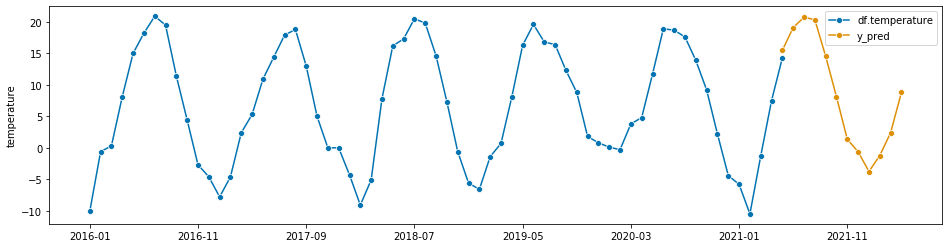

In [27]:
fh= np.arange(len(y_test))+12
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(df.temperature, y_pred, labels=["df.temperature", "y_pred"])
plt.show()

## 6. "Хождение в народ"

#### Будем использовать объединенную выборку RLMS по индивидам

In [282]:
df, meta = py.read_sav('i2018.SAV')
df.to_csv('file1.csv')
writer.save()

In [345]:
data = pd.read_csv('file1.csv', usecols = ['idind','w_age', 'wj1.1.2'],index_col = ['idind'])


## 7. "Кому на руси жить хорошо?"

#### Сформулируем вопрос: влияет ли возраст человека на его удовлетворенность от условий труда?

## 8. "Сделай красиво"

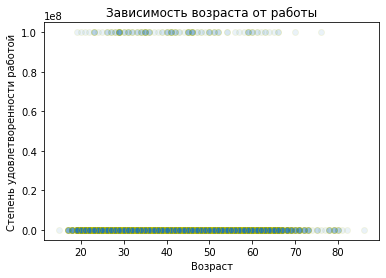

In [347]:
plt.scatter(data['w_age'], data['wj1.1.2'], alpha=0.09, edgecolors='y')

plt.xlabel('Возраст')
plt.ylabel('Степень удовлетворенности работой')
plt.title('Зависимость возраста от работы')
plt.show()

#### На графике видим, что особенно в 30 лет люди максимально удовлетворены условями труда. Однако совершенно точно об этом сказать нельзя. Поэтому проведем дальнейший анализ.

# 9. "Три сестры"

## Оценим сквозную модель

In [374]:
x = sm.tools.tools.add_constant(data['w_age'])
y = data['wj1.1.2']
value = PooledOLS(y, x)
result = mod.fit(cov_type='clustered', cluster_entity=True)
result

Dep. Variable:,wj1.1.2,R-squared:,7.246e-08
Estimator:,PooledOLS,R-squared (Between):,-0.0002
No. Observations:,7907,R-squared (Within):,2.314e-06
Date:,"Wed, Jun 16 2021",R-squared (Overall):,7.246e-08
Time:,15:17:04,Log-likelihood,-1.405e+05
Cov. Estimator:,Clustered,,
,,F-statistic:,0.0006
Entities:,39,P-value,0.9809
Avg Obs:,202.74,Distribution:,"F(1,7905)"
Min Obs:,26.000,,
Max Obs:,584.00,F-statistic (robust):,0.0007


#### Проведем тест Дарбина-Уотсона

In [394]:
data1 = pd.concat([data, residuals_pooled_OLS], axis=1)
data1 = data1.drop(['idind'], axis = 1).fillna(0)
x = sm.tools.tools.add_constant(dataset['w_age']).fillna(0)

d_watson= durbin_watson(pooled_OLS_dataset['residual']) 
d_watson

1.9487954114924768

#### Автокорреляция положительна, поэтому перейдем к RE и FE моделям

## Оценим FE-модель

In [351]:
x = sm.tools.tools.add_constant(dataset['w_age'])
y = data['wj1.1.2']

fe = PanelOLS(y, x, entity_effects = True) 
result = fe.fit() 

result

                          PanelOLS Estimation Summary                           
Dep. Variable:                wj1.1.2   R-squared:                     1.969e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0026
No. Observations:                7907   R-squared (Within):            1.969e-05
Date:                Wed, Jun 16 2021   R-squared (Overall):          -1.734e-05
Time:                        15:06:36   Log-likelihood                -1.405e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.1549
Entities:                          39   P-value                           0.6939
Avg Obs:                       202.74   Distribution:                  F(1,7867)
Min Obs:                       26.000                                           
Max Obs:                       584.00   F-statistic (robust):             0.1549
                            

## Оценим RE-модель

In [335]:
x = sm.tools.tools.add_constant(dataset['w_age'])
y = data['wj1.1.2']

re = PanelOLS(y, x, entity_effects = True) 
result = re.fit()

result

                          PanelOLS Estimation Summary                           
Dep. Variable:                wj1.1.2   R-squared:                     1.969e-05
Estimator:                   PanelOLS   R-squared (Between):             -0.0026
No. Observations:                7907   R-squared (Within):            1.969e-05
Date:                Wed, Jun 16 2021   R-squared (Overall):          -1.734e-05
Time:                        15:00:14   Log-likelihood                -1.405e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.1549
Entities:                          39   P-value                           0.6939
Avg Obs:                       202.74   Distribution:                  F(1,7867)
Min Obs:                       26.000                                           
Max Obs:                       584.00   F-statistic (robust):             0.1549
                            

#### Проведем тест Хаусмана, чтобы выбрать между FE и RE моделью

In [318]:
import numpy.linalg as la
from scipy import stats
import numpy as np
def hausman(fe, re):
    k = fe.params
    c = re.params
    k1 = fe.cov
    c1 = re.cov
    df = k[np.abs(k) < 1e8].size
    chi2 = np.dot((k - c).T, la.inv(k1 - c1).dot(k - c))
    p_value = stats.chi2.sf(chi2, df)
    return chi2, df, p_value


hausman_results = hausman(fe_res, re_res) 
hausman_results

(3.879212587084927, 2, 0.14376053808956482)

##### Так как p-value принимает большое значение, нулевая гипотеза не отвергается и RE модель является наилучшей моделью в нашем случае

## 10. "Ответ на главный вопрос"

#### Мы провели различные тесты и выявили, что независимая перменная является незначимой, значит взаимосвязи между возрастом и удовлетворенностью условиями труда нет